We were testing an adaptive linear control variate that goes through the initial condition.

8.29466881840891
8.390690868418941
3.0


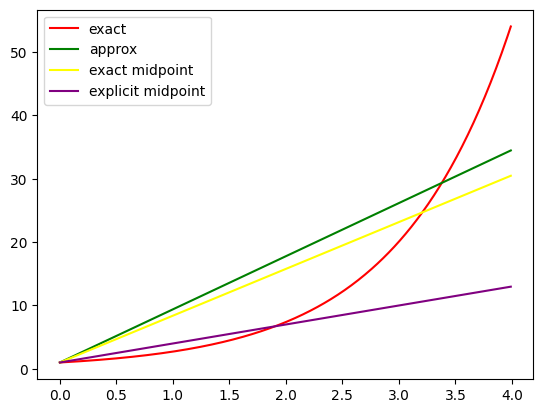

8.390690868418941


In [51]:
from random import random
import numpy as np
import matplotlib.pyplot as plt

def control(x,a): return a*x+1

def Y(t,a): 
    S = random()*t
    return 1+t +a*t**2/2 + ((Y(S,a)-control(S,a) if random()<t else 0) if t<1 else t*(Y(S,a)-control(S,a)) )

def A(t,a):
    S = random()*t  
    return a+ 3*(Y(S,a)- a*S-1)*S/t**2

t = 4
a_mid = 1+t/2
a,nsim = a_mid,10**3
for _ in range(2):
    a = sum(A(t,a) for _ in range(nsim))/nsim 
    print(a)

xs = np.arange(0,t,0.01)
ys = np.exp(xs)
zs = a*xs+1
qs  = np.exp(t/2)*xs+1
a_mid = 1+t/2
print(a_mid)
qs2 = a_mid*xs+1
plt.plot(xs,ys,color="red", label="exact")
plt.plot(xs,zs,color="green", label="approx")
plt.plot(xs,qs,color="yellow", label="exact midpoint")
plt.plot(xs,qs2,color="purple", label="explicit midpoint")

plt.legend()
plt.show()
print(a)
